In [5082]:
import pandas as pd
import json
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from pandas.io.json import json_normalize
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn import tree
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE 
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler

from sklearn.externals import joblib

data = pd.read_json('uebungs2datei.json')
data.tail()

,calEvents,datumBeginn,datumEnde,desc,gruppenName,name,newEvents,ort,score,speichern,uhrzeitBeginn,uhrzeitEnde,url
937,[],,,<p>Inhalt des 20. Info-Treffs</p> <p>C++ im Em...,C++ User Group Karlsruhe,C++ im Embedded-Medizinger�t � Lohnt der Einsa...,[],"Am Fasanengarten 5, Karlsruhe",16,True,,,https://www.meetup.com/C-User-Group-Karlsruhe/...
938,[],2018-09-01,2018-09-01,<p>OFFIZIELLER BOOTCAMP TRAILER?:<br/><a href=...,Bootcamp (Mannheim),Bootcamp,[],"Ecke Otto-Beck-Stra�e/Kolpingstra�e, Treffpunk...",19,True,11:00,12:00,https://www.meetup.com/Bootcamp-Mannheim/event...
939,[],2018-09-02,2018-09-02,<p>OFFIZIELLER BOOTCAMP TRAILER?:<br/><a href=...,Bootcamp Ludwigshafen,Bootcamp,[],"Saarlandstra�e 70, 67061 Ludwigshafen am Rhein...",19,True,11:00,12:00,https://www.meetup.com/Bootcamp-Ludwigshafen/e...
940,[],,,<p>Are you longing to hear and talk about that...,karlsruhe.ai,[Casual] Community Conversation about Machine ...,[],"Haid-und-Neu Str. 18, Karlsruhe, Karlsruhe",20,True,,,https://www.meetup.com/karlsruhe-ai/events/253...
941,[],,,"<p>In this event, we discuss scientific papers...",karlsruhe.ai,[PaperDiscussion] Computational Protein Design...,[],"Am Fasanengarten 5, Karlsruhe",23,True,,,https://www.meetup.com/karlsruhe-ai/events/253...


In [5083]:
data['speichern'].value_counts()

False    819
True     123
Name: speichern, dtype: int64

# HTML-Tags in Beschreibung entfernen

In [5084]:
imp_data = data[['speichern','desc','gruppenName','name','ort']]

In [5085]:
imp_data_plain = imp_data.copy()
imp_data_plain['desc']=imp_data['desc'].apply(lambda x : x.replace('"',''))
imp_data_plain['desc']=imp_data_plain['desc'].apply(lambda x : x.replace('<p>',''))
imp_data_plain['desc']=imp_data_plain['desc'].apply(lambda x : x.replace('</p>',''))
imp_data_plain['desc']=imp_data_plain['desc'].apply(lambda x : x.replace('<b>',''))
imp_data_plain['desc']=imp_data_plain['desc'].apply(lambda x : x.replace('</b>',''))
imp_data_plain['desc']=imp_data_plain['desc'].apply(lambda x : x.replace('\\n',''))
imp_data_plain['desc']=imp_data_plain['desc'].apply(lambda x : x.replace('\\>',''))
imp_data_plain['desc']=imp_data_plain['desc'].apply(lambda x : x.replace('/>',''))

In [5086]:
imp_data_plain.head()

,speichern,desc,gruppenName,name,ort
0,False,[Technisches Verst�ndnis und Kenntnisse in der...,NaN,,
1,False,Kultur im Cyberspace und jugendliche Lebenswel...,NaN,,
2,False,[Kommunikation mit Computern ist wundervoll ei...,NaN,,
3,False,Talklet (Vortrags- und Diskussionsabend) am Do...,NaN,,
4,False,"[NOSQL, Big Data und Graphen sind zur Zeit in ...",NaN,,


# Datenset splitten

In [5087]:
X_all = imp_data_plain.drop('speichern', axis=1)
Y_all = imp_data_plain["speichern"]

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

for train_index, test_index in sss.split(X_all, Y_all):
    X_train, X_test = X_all.iloc[train_index], X_all.iloc[test_index]
    Y_train, Y_test = Y_all.iloc[train_index], Y_all.iloc[test_index]

# Beschreibungen vectorisieren und Vokabular anlegen

In [5088]:
X_train_voc =  X_train['desc']

cv = TfidfVectorizer(token_pattern = '(?ui)\\b\\w*[a-z]\\w*[a-z]{5,20}\\b',min_df=0.02, max_df = 0.07, max_features = 200)

cv.fit(X_train_voc)
X_train_cv = cv.transform(X_train['desc'])

In [5089]:
len(X_train_voc)

753

In [5090]:
X_train_voc

9      Activiti als neue Open Source BPM Plattform ve...
903    In this event, we discuss scientific papers on...
495    Einladung zum ObjektForum Stuttgart \nam Monta...
492    Agile Nacht Stuttgart am Montag, 7. M�rz 2016,...
758    Moustafa<bris a self defense trainer and I has...
188    Dr. rer. nat. Rob van Stee\n\nElektronische Wa...
303    Speaker: Dr Heinz M. Kabutz (PhD CompSci) Auth...
582    [Parallele und nebenl�ufige Programmierung wir...
48     http://www.jug-bb.de/2013/08/graph-databases-w...
257    http://www.mac-ka.de/\n\nJeden 1. Donnerstag i...
448    Mobile Forum Stuttgart\nhttp://jugs.de/mfs/\n\...
170                           Infos: http://ka.linux.de/
737                                                     
839    [Grails ist ein Open-Source-Framework f�r die ...
185            http://ka.stadtwiki.net/Stadtwiki:Treffen
274    Neben den traditionell von einer Datenbank unt...
784    Let's get together and boulder at Cafe Kraft :...
450    Java Forum Stuttgart 201

In [5091]:
len(cv.get_feature_names())

194

In [5092]:
cv.get_feature_names()

['abstract',
 'agenda',
 'agilen',
 'aktuellen',
 'allerdings',
 'andere',
 'andrena',
 'anfahrt',
 'anforderungen',
 'anhand',
 'anschluss',
 'anwendung',
 'anwendungen',
 'apache',
 'application',
 'applications',
 'applikationen',
 'architekt',
 'architektur',
 'architekturen',
 'atmosph',
 'beispiel',
 'berblick',
 'bereich',
 'bereits',
 'berlin',
 'besser',
 'bieten',
 'bietet',
 'bitten',
 'brandenburg',
 'bringen',
 'business',
 'chlich',
 'community',
 'computer',
 'consultant',
 'degerloch',
 'design',
 'details',
 'deutschen',
 'deutschland',
 'developer',
 'development',
 'dienstag',
 'diesen',
 'dieses',
 'direkt',
 'diskussion',
 'diskussionsabend',
 'driven',
 'eclipse',
 'eigene',
 'eigenen',
 'eigentlich',
 'einige',
 'einsatz',
 'english',
 'enterprise',
 'entwickeln',
 'erfahrung',
 'erfahrungen',
 'ersten',
 'features',
 'finden',
 'findet',
 'fragen',
 'framework',
 'frameworks',
 'freuen',
 'gemeinsam',
 'gerade',
 'gezeigt',
 'glichen',
 'glichkeit',
 'glichkeite

In [5093]:
Y_train = Y_train.astype('int')

In [5094]:
Y_test = Y_test.astype('int')

In [5095]:
X_test_cv = cv.transform(X_test['desc'])

In [5096]:
def myEvaluation(y_pred):
    print(classification_report(Y_test, y_pred, digits=4))
    sns.heatmap(confusion_matrix(Y_test, y_pred), square=True, annot=True)
    plt.show()

# DecisionTree

             precision    recall  f1-score   support

          0     0.9198    0.9085    0.9141       164
          1     0.4444    0.4800    0.4615        25

avg / total     0.8569    0.8519    0.8542       189



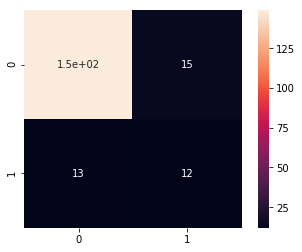

In [5122]:
clf_tree = tree.DecisionTreeClassifier(max_depth=25)
clf_tree.fit(X_train_cv, Y_train)
y_pred_tree = clf_tree.predict(X_test_cv)
myEvaluation(y_pred_tree)

# DecisionTree + ROS

             precision    recall  f1-score   support

          0     0.9172    0.8780    0.8972       164
          1     0.3750    0.4800    0.4211        25

avg / total     0.8455    0.8254    0.8342       189



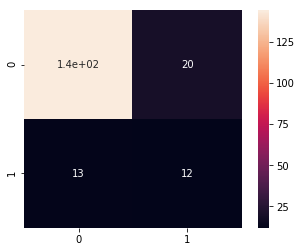

In [5098]:
ros = RandomOverSampler()
X_ros_res, y_ros_res = ros.fit_sample(X_train_cv, Y_train)
clf_tree2 = tree.DecisionTreeClassifier(max_depth=13)
clf_tree2.fit(X_ros_res, y_ros_res)
y_pred_tree = clf_tree2.predict(X_test_cv)
myEvaluation(y_pred_tree)

# DecisionTree + SMOTE

             precision    recall  f1-score   support

          0     0.9430    0.9085    0.9255       164
          1     0.5161    0.6400    0.5714        25

avg / total     0.8866    0.8730    0.8786       189



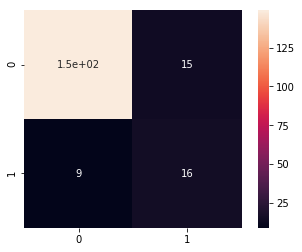

In [5099]:
s = SMOTE()
X_s_res, y_s_res = s.fit_sample(X_train_cv, Y_train)
clf_tree3 = tree.DecisionTreeClassifier(max_depth=15)
clf_tree3.fit(X_s_res, y_s_res)
y_pred_tree = clf_tree3.predict(X_test_cv)
myEvaluation(y_pred_tree)

# Decisiontree + ADASYN

             precision    recall  f1-score   support

          0     0.9456    0.8476    0.8939       164
          1     0.4048    0.6800    0.5075        25

avg / total     0.8740    0.8254    0.8428       189



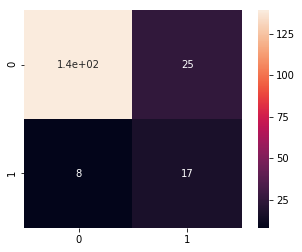

In [5100]:
ada = ADASYN()
X_ada_res, y_ada_res = ada.fit_sample(X_train_cv, Y_train)
clf_tree4 = tree.DecisionTreeClassifier()
clf_tree4.fit(X_ada_res, y_ada_res)
y_pred_tree = clf_tree4.predict(X_test_cv)
myEvaluation(y_pred_tree)

# DecisionTree + RandomUnderSampler

             precision    recall  f1-score   support

          0     0.9635    0.8049    0.8771       164
          1     0.3846    0.8000    0.5195        25

avg / total     0.8869    0.8042    0.8298       189



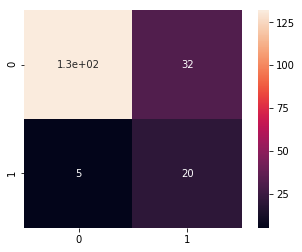

In [5101]:
rus = RandomUnderSampler()
X_rus_res, y_rus_res = rus.fit_sample(X_train_cv, Y_train)
clf_tree5 = tree.DecisionTreeClassifier()
clf_tree5.fit(X_rus_res, y_rus_res)
y_pred_tree = clf_tree5.predict(X_test_cv)
myEvaluation(y_pred_tree)

# RandomForestTree

             precision    recall  f1-score   support

          0     0.8907    0.9939    0.9395       164
          1     0.8333    0.2000    0.3226        25

avg / total     0.8831    0.8889    0.8579       189



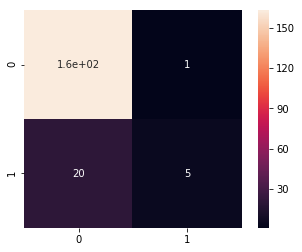

In [5102]:
clf_rdm_tree = RandomForestClassifier(n_estimators=100, max_depth=12)
clf_rdm_tree.fit(X_train_cv, Y_train)
y_pred_rdmForest = clf_rdm_tree.predict(X_test_cv)
myEvaluation(y_pred_rdmForest)

             precision    recall  f1-score   support

          0     0.9101    0.9878    0.9474       164
          1     0.8182    0.3600    0.5000        25

avg / total     0.8980    0.9048    0.8882       189



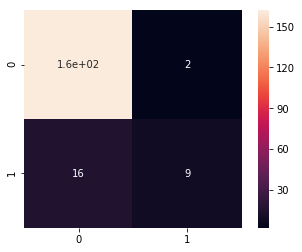

In [5127]:
clf_ext_tree = ExtraTreesClassifier(n_estimators=75, max_depth=50)
clf_ext_tree.fit(X_train_cv, Y_train)
y_pred_extTree = clf_ext_tree.predict(X_test_cv)
myEvaluation(y_pred_extTree)

# AdaBoostTree

             precision    recall  f1-score   support

          0     0.9394    0.9451    0.9422       164
          1     0.6250    0.6000    0.6122        25

avg / total     0.8978    0.8995    0.8986       189



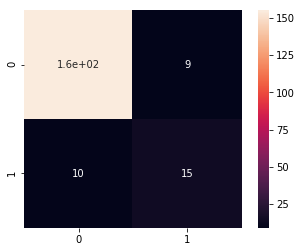

In [5135]:
clf_adaBoost_tree = AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=6),
                         algorithm="SAMME",
                         n_estimators= 70)

clf_adaBoost_tree.fit(X_train_cv, Y_train)
y_pred_adaBoost = clf_adaBoost_tree.predict(X_test_cv)
myEvaluation(y_pred_adaBoost)

             precision    recall  f1-score   support

          0     0.9317    0.9146    0.9231       164
          1     0.5000    0.5600    0.5283        25

avg / total     0.8746    0.8677    0.8709       189



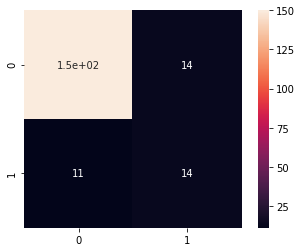

In [5105]:
rus = SMOTE()
X_rus_res, y_rus_res = rus.fit_sample(X_train_cv, Y_train)
clf_adaBoost_tree = AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=15),
                         algorithm="SAMME",
                         n_estimators= 100)

clf_adaBoost_tree.fit(X_rus_res, y_rus_res)
y_pred_adaBoost = clf_adaBoost_tree.predict(X_test_cv)
myEvaluation(y_pred_adaBoost)

# GradientBoostingTree

             precision    recall  f1-score   support

          0     0.9249    0.9756    0.9496       164
          1     0.7500    0.4800    0.5854        25

avg / total     0.9017    0.9101    0.9014       189



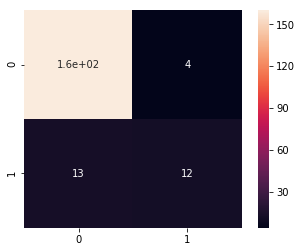

In [5144]:
clf_gradBoost_tree1 = GradientBoostingClassifier(n_estimators=75, learning_rate=0.1, max_depth=12)
clf_gradBoost_tree1.fit(X_train_cv, Y_train)
y_pred_gradBoost = clf_gradBoost_tree1.predict(X_test_cv)
myEvaluation(y_pred_gradBoost)

             precision    recall  f1-score   support

          0     0.9112    0.9390    0.9249       164
          1     0.5000    0.4000    0.4444        25

avg / total     0.8568    0.8677    0.8614       189



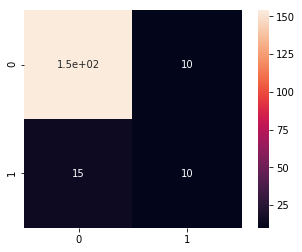

In [5137]:
clf_gradBoost_tree2 = GradientBoostingClassifier(n_estimators=300, learning_rate=0.1, max_depth=15)
clf_gradBoost_tree2.fit(X_train_cv, Y_train)
y_pred_gradBoost = clf_gradBoost_tree2.predict(X_test_cv)
myEvaluation(y_pred_gradBoost)

             precision    recall  f1-score   support

          0     0.9123    0.9512    0.9313       164
          1     0.5556    0.4000    0.4651        25

avg / total     0.8651    0.8783    0.8697       189



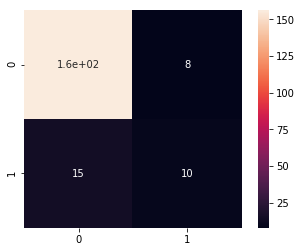

In [5108]:
clf_gradBoost_tree3 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=25)
clf_gradBoost_tree3.fit(X_train_cv, Y_train)
y_pred_gradBoost = clf_gradBoost_tree3.predict(X_test_cv)
myEvaluation(y_pred_gradBoost)

             precision    recall  f1-score   support

          0     0.9070    0.9512    0.9286       164
          1     0.5294    0.3600    0.4286        25

avg / total     0.8570    0.8730    0.8624       189



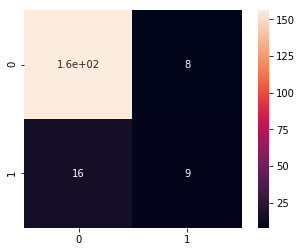

In [5109]:
clf_gradBoost_tree4 = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=75)
clf_gradBoost_tree4.fit(X_train_cv, Y_train)
y_pred_gradBoost = clf_gradBoost_tree4.predict(X_test_cv)
myEvaluation(y_pred_gradBoost)

             precision    recall  f1-score   support

          0     0.9181    0.9573    0.9373       164
          1     0.6111    0.4400    0.5116        25

avg / total     0.8775    0.8889    0.8810       189



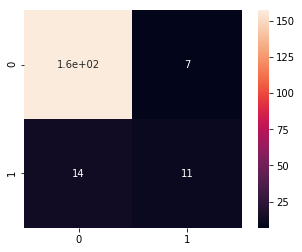

In [5110]:
clf_gradBoost_tree5 = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=100)
clf_gradBoost_tree5.fit(X_train_cv, Y_train)
y_pred_gradBoost = clf_gradBoost_tree5.predict(X_test_cv)
myEvaluation(y_pred_gradBoost)

             precision    recall  f1-score   support

          0     0.9172    0.9451    0.9309       164
          1     0.5500    0.4400    0.4889        25

avg / total     0.8686    0.8783    0.8725       189



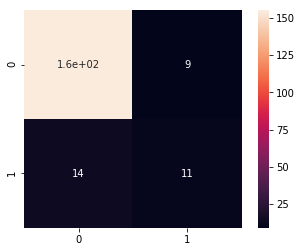

In [5111]:
clf_gradBoost_tree6 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=40)
clf_gradBoost_tree6.fit(X_train_cv, Y_train)
y_pred_gradBoost = clf_gradBoost_tree6.predict(X_test_cv)
myEvaluation(y_pred_gradBoost)

             precision    recall  f1-score   support

          0     0.9123    0.9512    0.9313       164
          1     0.5556    0.4000    0.4651        25

avg / total     0.8651    0.8783    0.8697       189



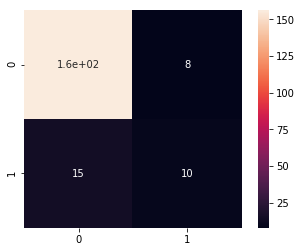

In [5112]:
clf_gradBoost_tree7 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=30)
clf_gradBoost_tree7.fit(X_train_cv, Y_train)
y_pred_gradBoost = clf_gradBoost_tree7.predict(X_test_cv)
myEvaluation(y_pred_gradBoost)

             precision    recall  f1-score   support

          0     0.9167    0.9390    0.9277       164
          1     0.5238    0.4400    0.4783        25

avg / total     0.8647    0.8730    0.8683       189



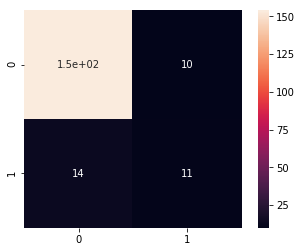

In [5113]:
clf_gradBoost_tree8 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=20)
clf_gradBoost_tree8.fit(X_train_cv, Y_train)
y_pred_gradBoost = clf_gradBoost_tree8.predict(X_test_cv)
myEvaluation(y_pred_gradBoost)

# GradientBoostingTree + ROS

             precision    recall  f1-score   support

          0     0.9545    0.8963    0.9245       164
          1     0.5143    0.7200    0.6000        25

avg / total     0.8963    0.8730    0.8816       189



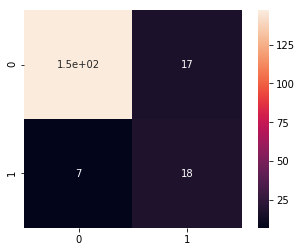

In [5114]:
ros = RandomOverSampler()
X_ros_res, y_ros_res = ros.fit_sample(X_train_cv, Y_train)
clf_gradBoost_tree9 = GradientBoostingClassifier(n_estimators=75, learning_rate=0.1, max_depth=50)
clf_gradBoost_tree9.fit(X_rus_res, y_rus_res)
y_pred_gradBoost = clf_gradBoost_tree9.predict(X_test_cv)
myEvaluation(y_pred_gradBoost)

# GradientBoostingTree + RUS

             precision    recall  f1-score   support

          0     0.9675    0.7256    0.8293       164
          1     0.3182    0.8400    0.4615        25

avg / total     0.8816    0.7407    0.7806       189



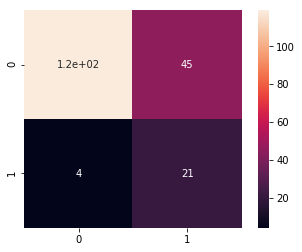

In [5115]:
rus = RandomUnderSampler()
X_rus_res, y_rus_res = rus.fit_sample(X_train_cv, Y_train)
clf_gradBoost_tree10 = GradientBoostingClassifier(n_estimators=75, learning_rate=0.1, max_depth=30)
clf_gradBoost_tree10.fit(X_rus_res, y_rus_res)
y_pred_gradBoost = clf_gradBoost_tree10.predict(X_test_cv)
myEvaluation(y_pred_gradBoost)

In [5145]:
joblib.dump(clf_gradBoost_tree1 , 'clf_gradBoost_tree.pkl') 

['clf_gradBoost_tree.pkl']

In [5146]:
 joblib.dump(cv, 'vectorizer.pkl')

['vectorizer.pkl']